# Plots Dataset
We plot the label distribution, the sequence length distribution, as well as the signal of a few samples.

In [1]:
import sys

sys.path.append("..")
import os

os.environ["MPLCONFIGDIR"] = "/myhome"
from data import BreizhCrops
from torch.utils.data import DataLoader
from models.earlyrnn import EarlyRNN
import torch
from tqdm import tqdm
from utils.losses.early_reward_loss import EarlyRewardLoss
import sklearn.metrics
import pandas as pd
import wandb
from utils.plots import (
    plot_label_distribution_datasets,
    boxplot_stopping_times,
    plot_spectral_bands,
)
from utils.doy import (
    get_doys_dict_test,
    get_doy_stop,
    create_sorted_doys_dict_test,
    get_approximated_doys_dict,
    get_approximated_doy,
)
from utils.train.helpers_training import train_epoch

from utils.metrics import harmonic_mean_score
import matplotlib.pyplot as plt
from models.model_helpers import count_parameters
import seaborn as sns


PALETTE = sns.color_palette("colorblind")

%load_ext autoreload
%autoreload 2

In [2]:
data_path = os.path.join(
    os.environ.get("HOME", os.environ.get("USERPROFILE")), "elects_data"
)
dataset = "breizhcrops"
sequence_length = 150
dataroot = os.path.join(data_path, "breizhcrops")
nclasses = 9
input_dim = 13
print("get doys dict test")
doys_dict_test = get_doys_dict_test(dataroot=os.path.join(data_path, dataset))
length_sorted_doy_dict_test = create_sorted_doys_dict_test(doys_dict_test)
print("get doys dict test done")

get doys dict test
get doys dict test done


In [3]:
print("get train and validation data...")
test_ds = BreizhCrops(
    root=dataroot, partition="eval", sequencelength=sequence_length, return_id=True
)
class_names = test_ds.ds.classname
print("class names:", class_names)

get train and validation data...
1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [03:23<00:00, 601.97it/s]


class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


Sample 6032441 has label permanent meadows


(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Day of year'>)

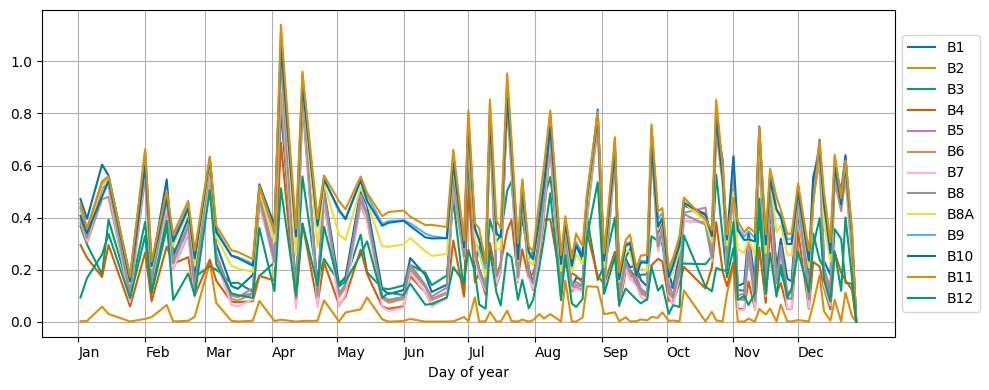

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
idx = 11498
plot_spectral_bands(idx, test_ds, doys_dict_test, class_names, fig, ax)

Sample 6032238 has label corn


(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Day of year'>)

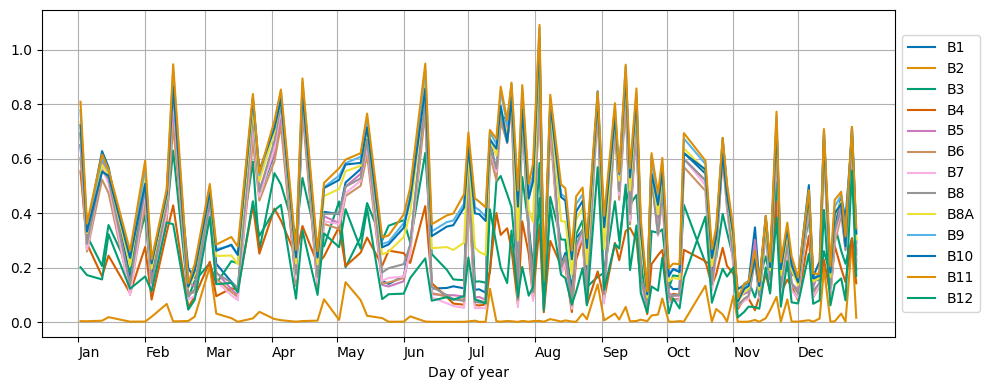

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
idx = 11345
plot_spectral_bands(idx, test_ds, doys_dict_test, class_names, fig, ax)

## Count number of parcels per dataset

In [6]:
print("test_ds length:", len(test_ds))

test_ds length: 122614


In [7]:
train_ds = BreizhCrops(
    root=dataroot, partition="train", sequencelength=sequence_length, return_id=True
)
print("train_ds length:", len(train_ds))

2559635960 2559635960


loading data into RAM: 100%|██████████| 178613/178613 [04:57<00:00, 599.78it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 140645/140645 [04:05<00:00, 572.19it/s]


train_ds length: 319258


In [8]:
valid_ds = BreizhCrops(
    root=dataroot, partition="valid", sequencelength=sequence_length, return_id=True
)
print("valid_ds length:", len(valid_ds))

2493572704 2493572704


loading data into RAM: 100%|██████████| 166391/166391 [01:50<00:00, 1510.72it/s]

valid_ds length: 166391


In [9]:
# sum of all the samples:
print("sum of all samples:", len(train_ds) + len(valid_ds) + len(test_ds))

sum of all samples: 608263


# plot label distribution 

Extracting labels from dataset Train.
Extracting labels from dataset Validation.
Extracting labels from dataset Test.


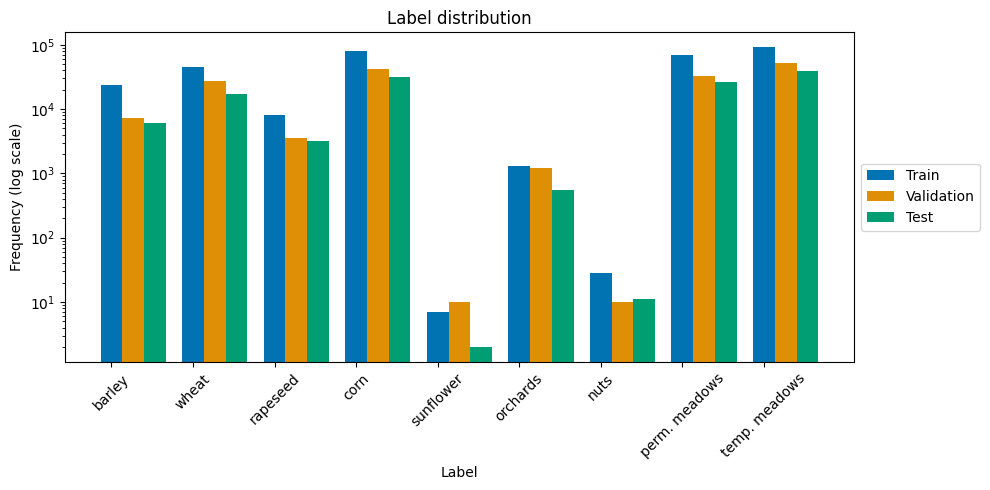

In [10]:
datasets = [train_ds, valid_ds, test_ds]
sets_labels = ["Train", "Validation", "Test"]
fig, ax = plt.subplots(figsize=(10, 5))
fig, ax = plot_label_distribution_datasets(
    datasets, sets_labels, fig, ax, title="Label distribution", labels_names=class_names
)

## Plot distribution of sequence length

In [11]:
dataroot = os.path.join(
    os.environ.get("HOME", os.environ.get("USERPROFILE")), "elects_data"
)
doys_dict = get_doys_dict_test(dataroot=dataroot)

In [12]:
# go through all the test samples and get the index
lengths = []
for _, _, idx in test_ds:
    length = len(doys_dict[idx])
    lengths.append(length)

In [13]:
all_lengths = []
datasets_dict = {
    "Train": train_ds,
    "Validation": valid_ds,
    "Test": test_ds,
}
for name, ds in datasets_dict.items():
    print(f"dataset: {name}")
    temp_lengths = []
    for X, _, idx in ds:
        # if the idx is not in the doys_dict, then the length is computed as the number of non zero elements in X
        if idx not in doys_dict:
            length = (X[:, 0] != 0).sum().item()
        else:
            length = len(doys_dict[idx])
            computed_length = (X[:, 0] != 0).sum().item()
            other_computed_length = (X[:, 1] != 0).sum().item()
            # if length != computed_length:
            #     print(f"idx: {idx}, length: {length}, computed_length: {computed_length}")
            # if computed_length != other_computed_length:
            #     print(f"idx: {idx}, computed_length: {computed_length}, other_computed_length: {other_computed_length}")

        temp_lengths.append(length)
    all_lengths.append(temp_lengths)
    print(
        f"min: {min(temp_lengths)}, max: {max(temp_lengths)}, mean: {sum(temp_lengths)/len(temp_lengths)}"
    )

dataset: Train
min: 50, max: 103, mean: 84.33494227239412
dataset: Validation
min: 49, max: 103, mean: 85.86884506974536
dataset: Test
min: 49, max: 104, mean: 69.56733325721369


Text(0.5, 1.0, 'Histogram of sequence lengths')

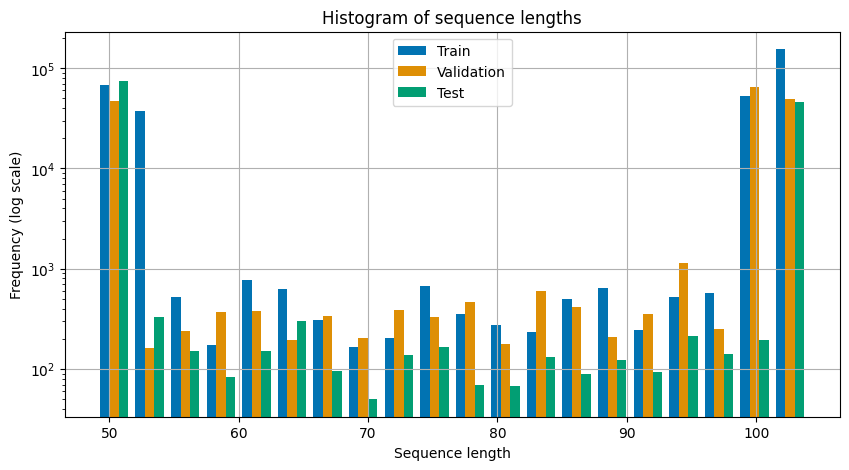

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    all_lengths,
    bins=20,
    label=["Train", "Validation", "Test"],
    histtype="bar",
    color=PALETTE[0:3],
    log=True,
)
ax.legend()
ax.set_ylabel("Frequency (log scale)")
ax.set_xlabel("Sequence length")
ax.grid()
ax.set_title("Histogram of sequence lengths")

According to Breizhcrops paper, L1C level data has either 51 or 102 length. 

If we look at the test set, two lengths can be observed: 
- number of non zero elements in the sequence,
- length given by the doys dictionary. 

They are unconsistent. That's why we trust the length in the csv files.

## Get the raw length 
Since we notice that the data lengths is not either 51 or 102, something is off. Let's load the raw length of the data.

In [15]:
all_data_path = os.path.join(data_path, "breizhcrops", "2017", "L1C")
files = ["frh0" + str(i) + ".csv" for i in range(1, 5)]
dfs = []
for file in files:
    df = pd.read_csv(os.path.join(all_data_path, file))
    dfs.append(df)
df = pd.concat(dfs)

In [16]:
df.head()

,idx,id,CODE_CULTU,path,meanCLD,sequencelength,classid,classname,region
0,2,6017310,CZH,csv/frh01/6017310.csv,710.327555,50,2,rapeseed,frh01
1,3,6017311,BTH,csv/frh01/6017311.csv,717.753189,50,1,wheat,frh01
2,8,6021325,BTH,csv/frh01/6021325.csv,716.923683,50,1,wheat,frh01
3,12,6021396,PPH,csv/frh01/6021396.csv,716.800000,50,7,permanent meadows,frh01
4,14,6021404,ORP,csv/frh01/6021404.csv,736.644828,50,0,barley,frh01


C:\Users\anyam\AppData\Local\Temp\ipykernel_53328\1100029769.py:3: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.histplot(data=df, x="sequencelength", hue="region", bins=25, ax=ax, kde=True, palette=PALETTE, log_scale=True)


Text(0.5, 1.0, 'Histogram of sequence lengths for each dataset')

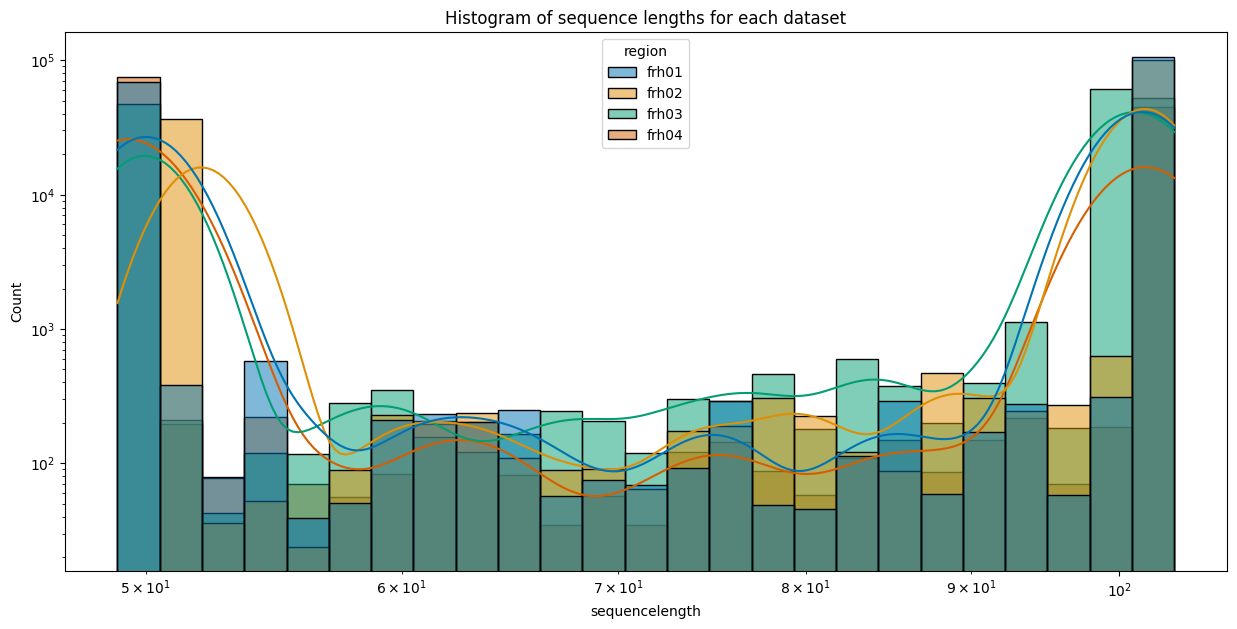

In [17]:
# plot the distribution of sequencelength of df, where the colors are determined by the filename
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(
    data=df,
    x="sequencelength",
    hue="region",
    bins=25,
    ax=ax,
    kde=True,
    palette=PALETTE,
    log_scale=True,
)
# set the y_axis to log scale
ax.set_yscale("log")
ax.set_title("Histogram of sequence lengths for each dataset")

In [18]:
# count the number of samples with 50<length<100 in the test set
print(
    "number of samples with 50<length<100 in the test set:",
    df[df["region"] == "frh04"]["sequencelength"].between(50, 100).sum(),
)
print(
    "fraction of samples with 50<length<100 in the test set:",
    df[df["region"] == "frh04"]["sequencelength"].between(50, 100).sum()
    / len(df[df["region"] == "frh04"]),
)

number of samples with 50<length<100 in the test set: 30927
fraction of samples with 50<length<100 in the test set: 0.25223057725871434


In [19]:
# count the number of samples with length==51 or  102 in the test set
print(
    "number of samples with length==51 or 102 in the test set:",
    (df[df["region"] == "frh04"]["sequencelength"] == 51).sum()
    + (df[df["region"] == "frh04"]["sequencelength"] == 102).sum(),
)
# count the fraction of samples with length==51, 102 in the test set
print(
    "fraction of samples with length==51 or 102 in the test set:",
    (
        (df[df["region"] == "frh04"]["sequencelength"] == 51).sum()
        + (df[df["region"] == "frh04"]["sequencelength"] == 102).sum()
    )
    / len(df[df["region"] == "frh04"]),
)

number of samples with length==51 or 102 in the test set: 37045
fraction of samples with length==51 or 102 in the test set: 0.30212700017942484


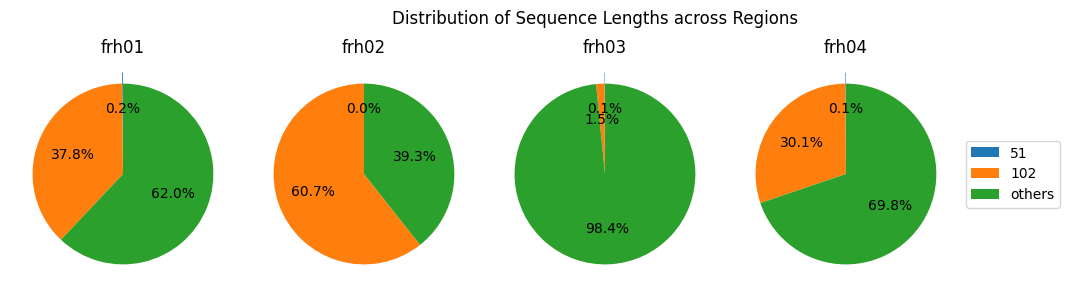

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))  # Increased figure size
for j, ax in enumerate(axes):
    region = df["region"].unique()
    region = region[j]
    data = df[df["region"] == region]
    sequence_lengths = data["sequencelength"]
    labels = ["51", "102", "others"]
    sizes = [
        (sequence_lengths == 51).sum(),
        (sequence_lengths == 102).sum(),
        (~sequence_lengths.isin([51, 102])).sum(),
    ]
    explode = (0.12, 0, 0)  # Explode the first slice
    pie_wedges = ax.pie(sizes, autopct="%1.1f%%", startangle=90, explode=explode)
    ax.set_title(f"{region}")

# Add a legend outside the last plot
axes[-1].legend(pie_wedges[0], labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

fig.suptitle("Distribution of Sequence Lengths across Regions")
fig.tight_layout(
    rect=[0, 0, 0.9, 1]
)  # Adjust the right margin to make room for the legend
plt.show()

## Create datasets with lengths of 51 or 102
The datasets need to be reoganized to have a length of 51 or 102, such that they have enough samples. Indeed, region frh03 has less than 3000 samples after keeping only the samples with 51 or 102 length. From there, we organize as follows: 
- train: frh02
- valid: frh01
- test: frh03 + frh04

In [21]:
data_path = os.path.join(
    os.environ.get("HOME", os.environ.get("USERPROFILE")), "elects_data"
)
dataset = "breizhcrops"
sequence_length = 150
dataroot = os.path.join(data_path, "breizhcrops")
nclasses = 9
input_dim = 13
original_time_serie_lengths = [51, 102]

corrected = True
test_ds = BreizhCrops(
    root=dataroot,
    partition="eval",
    sequencelength=sequence_length,
    return_id=True,
    corrected=corrected,
    original_time_serie_lengths=original_time_serie_lengths,
)
train_ds = BreizhCrops(
    root=dataroot,
    partition="train",
    sequencelength=sequence_length,
    return_id=True,
    corrected=corrected,
    original_time_serie_lengths=original_time_serie_lengths,
)
valid_ds = BreizhCrops(
    root=dataroot,
    partition="valid",
    sequencelength=sequence_length,
    return_id=True,
    corrected=corrected,
    original_time_serie_lengths=original_time_serie_lengths,
)

2493572704 2493572704


loading data into RAM: 100%|██████████| 2596/2596 [00:02<00:00, 1185.85it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 37045/37045 [00:17<00:00, 2103.93it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 85310/85310 [00:37<00:00, 2253.47it/s]


2559635960 2559635960


loading data into RAM: 100%|██████████| 67795/67795 [00:33<00:00, 2021.25it/s]


In [26]:
class_names = valid_ds.labels_names
dataroot = os.path.join(
    os.environ.get("HOME", os.environ.get("USERPROFILE")), "elects_data"
)
doys_dict = get_doys_dict_test(dataroot=dataroot)

In [22]:
all_lengths = []
datasets_dict = {"test": test_ds, "train": train_ds, "valid": valid_ds}
for name, ds in datasets_dict.items():
    print("_" * 50)
    print(f"dataset: {name}")
    temp_lengths = []
    for X, _, idx in ds:
        length = (X[:, 0] != 0).sum().item()
        temp_lengths.append(length)
    all_lengths.append(temp_lengths)
    print(
        f"min: {min(temp_lengths)}, max: {max(temp_lengths)}, mean: {sum(temp_lengths)/len(temp_lengths)}"
    )
    print(f"unique lengths: {set(temp_lengths)}")
    print(f"size: {len(temp_lengths)}")

__________________________________________________
dataset: test
min: 51, max: 102, mean: 101.66163820287076
unique lengths: {51, 102}
size: 39641
__________________________________________________
dataset: train
min: 102, max: 102, mean: 102.0
unique lengths: {102}
size: 85310
__________________________________________________
dataset: valid
min: 51, max: 102, mean: 101.79538314034959
unique lengths: {51, 102}
size: 67795


Text(0.5, 1.0, 'Histogram of sequence lengths')

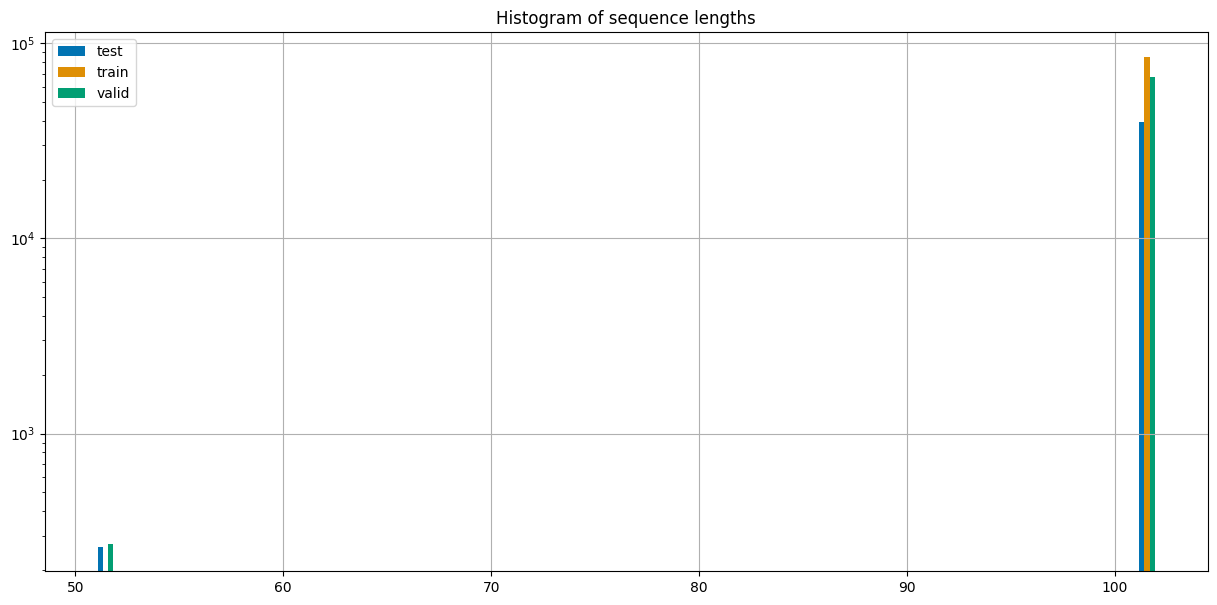

In [23]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(
    all_lengths,
    bins=104 - 49,
    label=["test", "train", "valid"],
    histtype="bar",
    color=PALETTE[0:3],
    log=True,
)
ax.legend()
ax.grid()
ax.set_title("Histogram of sequence lengths")

datasets: [<data.breizhcrops.BreizhCrops object at 0x000001DAB5AB6C10>, <data.breizhcrops.BreizhCrops object at 0x000001DB3E721250>, <data.breizhcrops.BreizhCrops object at 0x000001DB47119A90>]
sets_labels: ['test', 'train', 'valid']
Extracting labels from dataset test.
Extracting labels from dataset train.
Extracting labels from dataset valid.


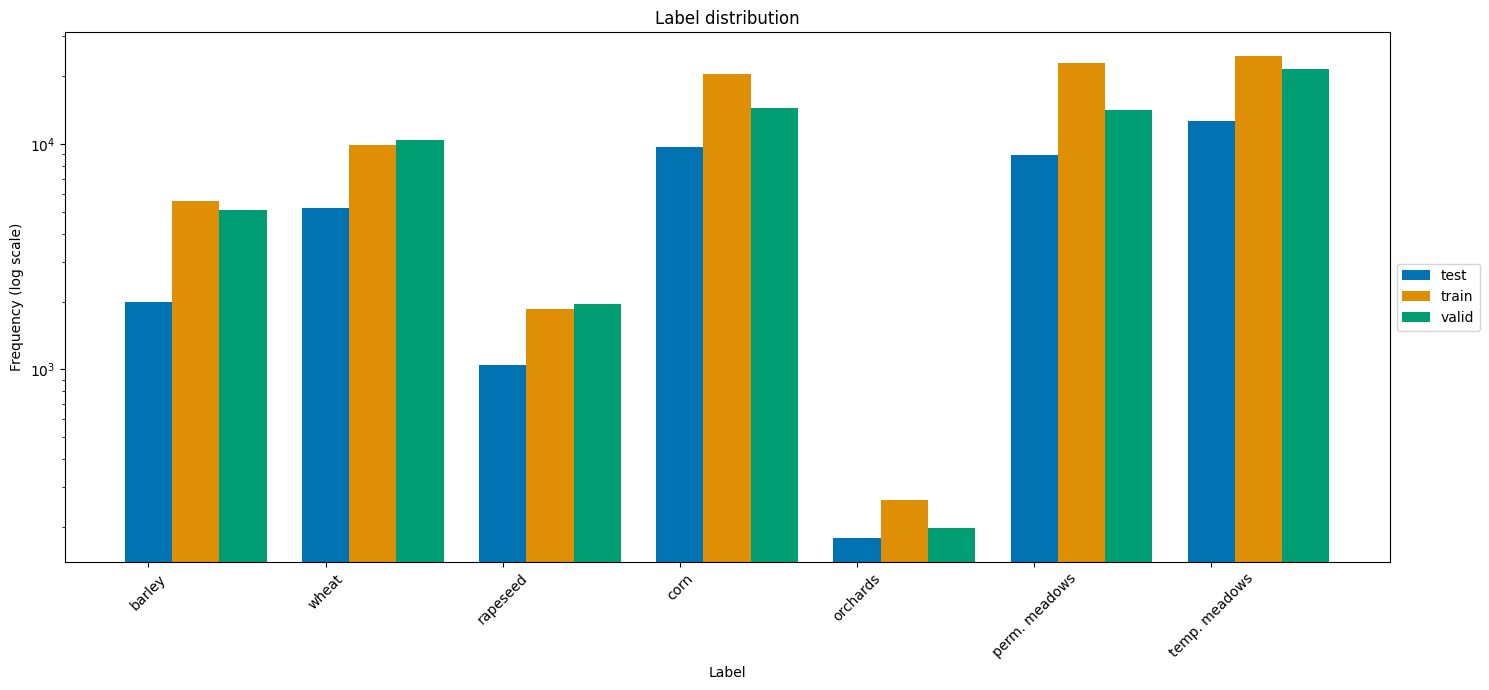

In [28]:
datasets = list(datasets_dict.values())
sets_labels = list(datasets_dict.keys())
print("datasets:", datasets)
print("sets_labels:", sets_labels)
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(
    datasets, sets_labels, fig, ax, title="Label distribution", labels_names=class_names
)

The new datasets with either 51 or 102 lengths have differents distributions of labels. For example, there are no or almost no parcels with labels sunflowers and nuts in the test and validations sets. 

Text(0, 0.5, 'Number of samples')

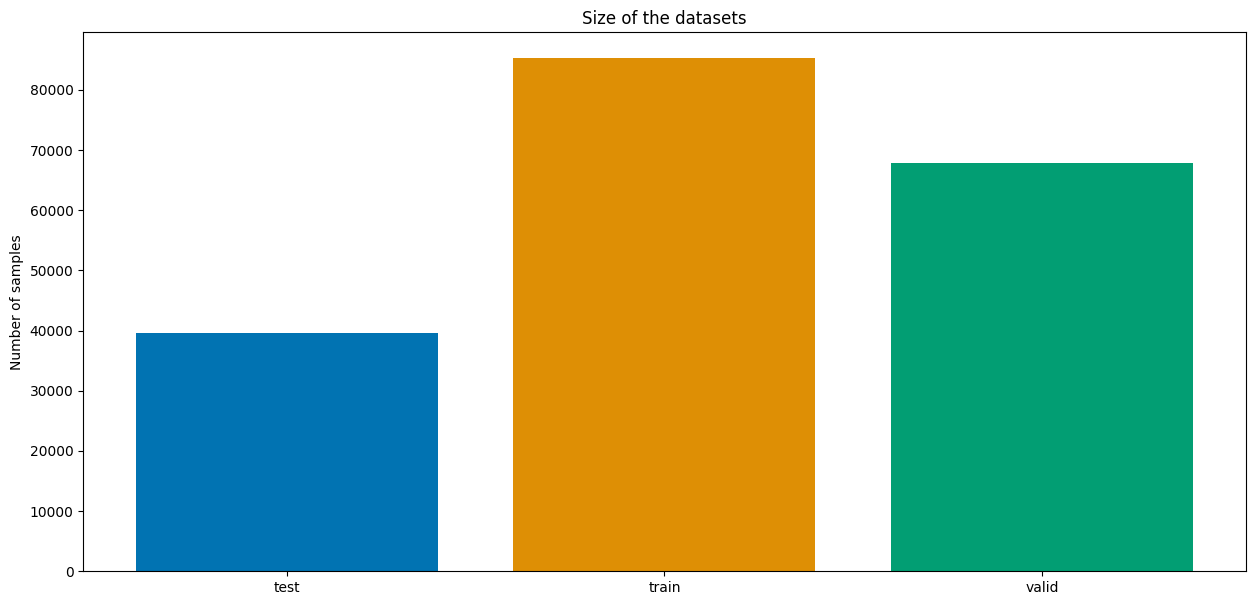

In [29]:
# compare the size of the datasets
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(sets_labels, [len(ds) for ds in datasets], color=PALETTE[0:3])
ax.set_title("Size of the datasets")
ax.set_ylabel("Number of samples")

## Timestamps in days 
For later use, we will save the datasets with timestamps representing days. From there we need doys dictionary to get the day of the year from the length of the sequence.

Moreover, since by removing the smaller classes nuts and sunflowers, the train dataset does not have any samples with length 51, we will only keep the samples with length 102. This should not cause an issue since most of the datasets have samples of length 102.

In [30]:
print(
    "approximated doy for length 51:\n", get_approximated_doy(51, doys_dict_test), "\n"
)
print("approximated doy for length 102:\n", get_approximated_doy(102, doys_dict_test))

approximated doy for length 51:
 [  2  12  15  32  42  52  62  72  82  92 102 112 122 132 142 152 162 172
 182 187 192 197 202 207 212 217 227 232 237 242 252 257 262 267 272 277
 282 292 297 302 307 312 317 322 327 332 342 347 352 357 362] 

approximated doy for length 102:
 [  2   5  12  15  25  32  35  42  45  52  55  62  65  72  75  82  85  92
  95 102 105 112 115 122 125 132 135 142 145 152 155 162 165 172 175 180
 182 185 187 190 192 195 197 200 202 205 207 210 212 215 217 220 225 227
 230 232 235 237 242 245 250 252 255 257 260 262 265 267 270 272 275 277
 280 282 292 295 297 300 302 305 307 310 312 315 317 320 322 325 327 330
 332 335 340 342 345 347 350 352 355 357 360 362]


In [32]:
data_path = os.path.join(
    os.environ.get("HOME", os.environ.get("USERPROFILE")), "elects_data"
)
dataset = "breizhcrops"
sequence_length = 365
dataroot = os.path.join(data_path, "breizhcrops")
nclasses = 9
input_dim = 13

corrected = True
daily_timestamps = True
original_time_serie_lengths = [102]
test_ds = BreizhCrops(
    root=dataroot,
    partition="eval",
    sequencelength=sequence_length,
    return_id=True,
    corrected=corrected,
    daily_timestamps=daily_timestamps,
    original_time_serie_lengths=original_time_serie_lengths,
)
train_ds = BreizhCrops(
    root=dataroot,
    partition="train",
    sequencelength=sequence_length,
    return_id=True,
    corrected=corrected,
    daily_timestamps=daily_timestamps,
    original_time_serie_lengths=original_time_serie_lengths,
)
valid_ds = BreizhCrops(
    root=dataroot,
    partition="valid",
    sequencelength=sequence_length,
    return_id=True,
    corrected=corrected,
    daily_timestamps=daily_timestamps,
    original_time_serie_lengths=original_time_serie_lengths,
)

class_names = valid_ds.labels_names
dataroot = os.path.join(
    os.environ.get("HOME", os.environ.get("USERPROFILE")), "elects_data"
)
doys_dict = get_doys_dict_test(dataroot=dataroot)

2493572704 2493572704


loading data into RAM: 100%|██████████| 2463/2463 [00:00<00:00, 5714.03it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 36915/36915 [00:12<00:00, 2946.53it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 85310/85310 [00:36<00:00, 2318.17it/s]


2559635960 2559635960


loading data into RAM: 100%|██████████| 67523/67523 [00:29<00:00, 2283.15it/s]


In [33]:
all_lengths = []
datasets_dict = {"Train": train_ds, "Validation": valid_ds, "Test": test_ds}
for name, ds in datasets_dict.items():
    print("_" * 50)
    print(f"dataset: {name}")
    temp_lengths = []
    for X, _, idx in ds:
        length = (X[:, 0] != 0).sum().item()
        temp_lengths.append(length)
    all_lengths.append(temp_lengths)
    print(
        f"min: {min(temp_lengths)}, max: {max(temp_lengths)}, mean: {sum(temp_lengths)/len(temp_lengths)}"
    )
    print(f"unique lengths: {set(temp_lengths)}")
    print(f"size: {len(temp_lengths)}")

__________________________________________________
dataset: Train
min: 102, max: 102, mean: 102.0
unique lengths: {102}
size: 85310
__________________________________________________
dataset: Validation
min: 102, max: 102, mean: 102.0
unique lengths: {102}
size: 67523
__________________________________________________
dataset: Test
min: 102, max: 102, mean: 102.0
unique lengths: {102}
size: 39378


Text(0.5, 1.0, 'Histogram of sequence lengths')

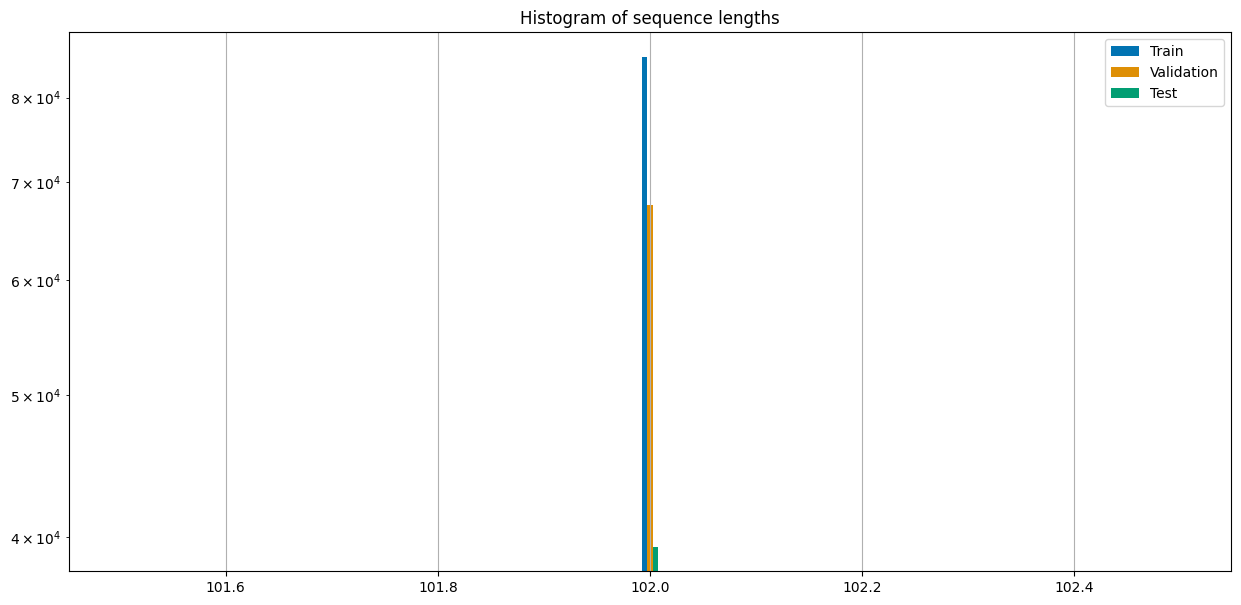

In [34]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(
    all_lengths,
    bins=104 - 49,
    label=["Train", "Validation", "Test"],
    histtype="bar",
    color=PALETTE[0:3],
    log=True,
)
ax.legend()
ax.grid()
ax.set_title("Histogram of sequence lengths")

datasets: [<data.breizhcrops.BreizhCrops object at 0x000001D9630C9250>, <data.breizhcrops.BreizhCrops object at 0x000001D960F8DC90>, <data.breizhcrops.BreizhCrops object at 0x000001D963059490>]
sets_labels: ['Train', 'Validation', 'Test']
Extracting labels from dataset Train.
Extracting labels from dataset Validation.
Extracting labels from dataset Test.


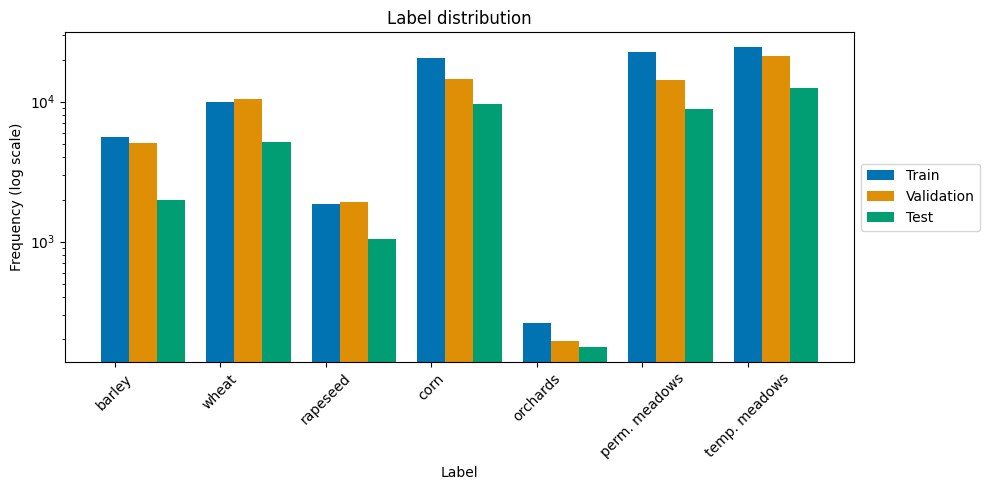

In [35]:
datasets = list(datasets_dict.values())
sets_labels = list(datasets_dict.keys())
print("datasets:", datasets)
print("sets_labels:", sets_labels)
fig, ax = plt.subplots(figsize=(10, 5))
fig, ax = plot_label_distribution_datasets(
    datasets, sets_labels, fig, ax, title="Label distribution", labels_names=class_names
)

Text(0, 0.5, 'Number of samples')

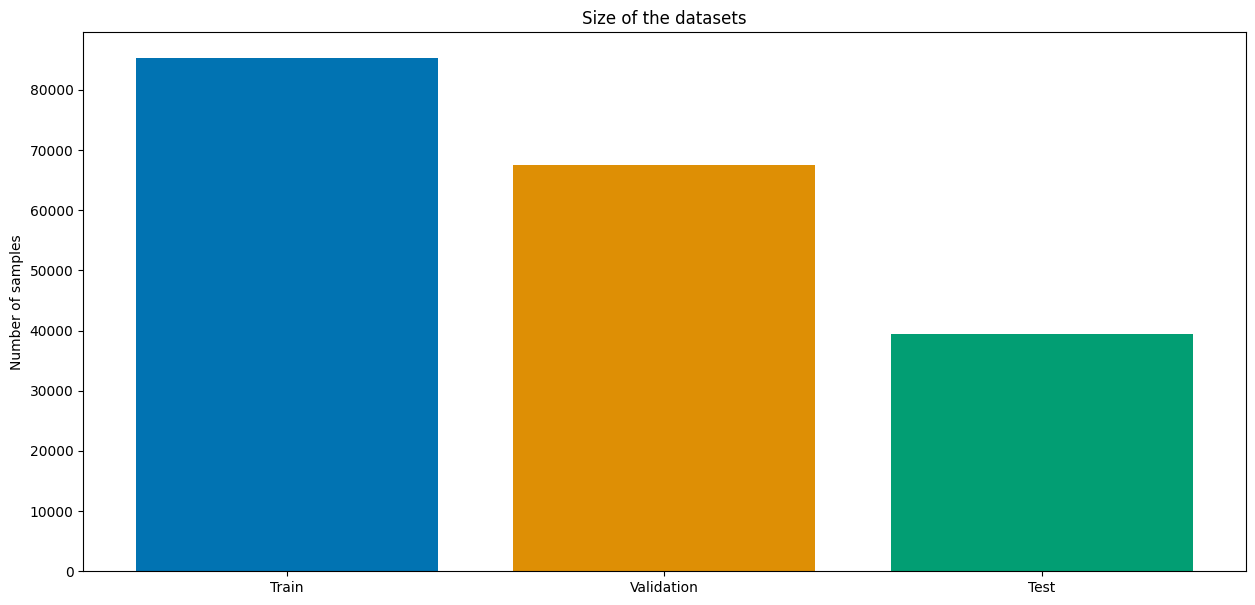

In [36]:
# compare the size of the datasets
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(sets_labels, [len(ds) for ds in datasets], color=PALETTE[0:3])
ax.set_title("Size of the datasets")
ax.set_ylabel("Number of samples")

Let's look at one sample to understand the new structure:

X shape: torch.Size([365, 13])
y shape: torch.Size([365])


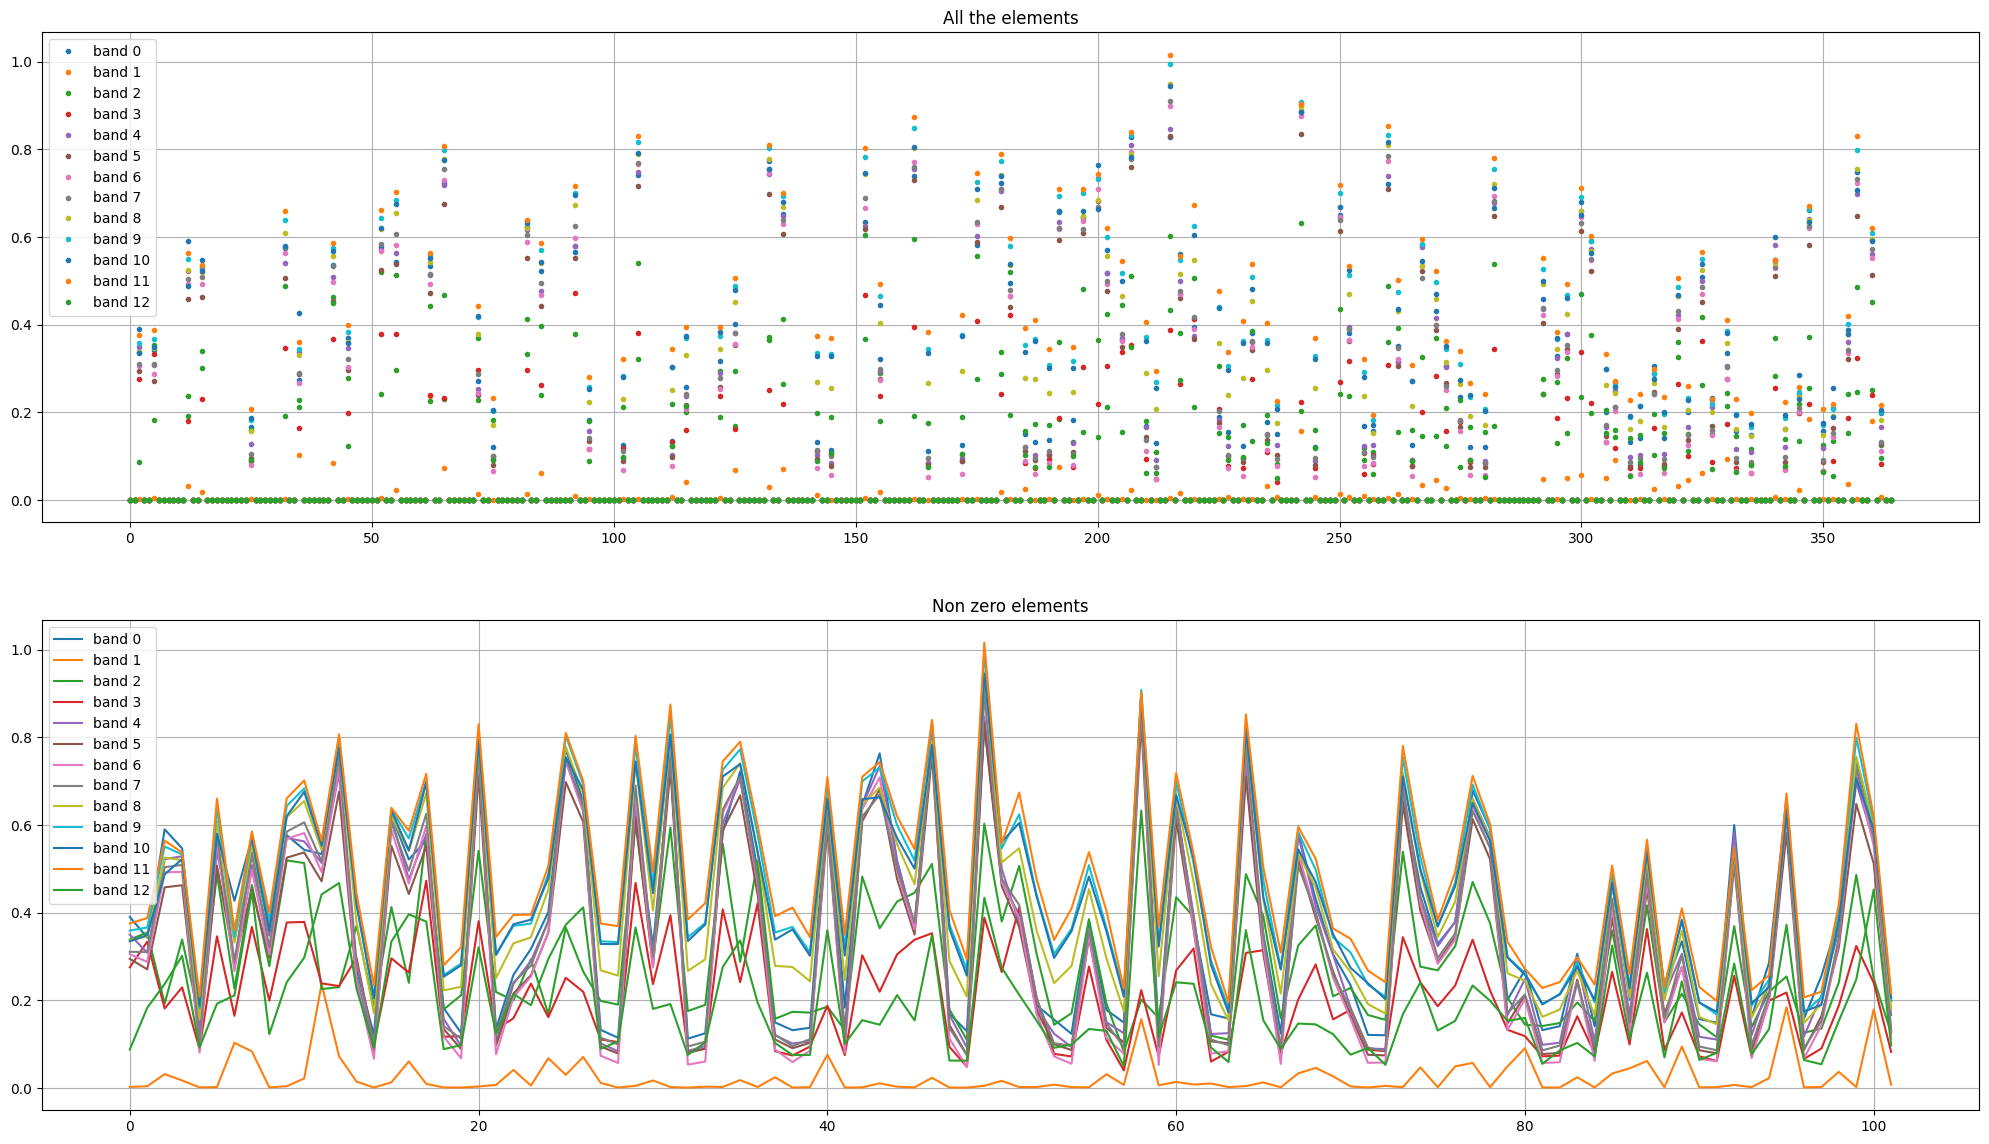

In [37]:
idx = 11345
X, y, id = test_ds[idx]
print("X shape:", X.shape)
print("y shape:", y.shape)
fig, axes = plt.subplots(2, figsize=(25, 14), sharey=True)

for i in range(13):
    axes[0].plot(X[:, i], ".", label=f"band {i}")

# only plot the non zero elements
for i in range(13):
    axes[1].plot(X[X[:, i] != 0, i], label=f"band {i}")

axes[0].set_title("All the elements")
axes[1].set_title("Non zero elements")

for ax in axes:
    ax.legend()
    ax.grid()

Sample 6051309 has label temporary meadows


(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Day of year'>)

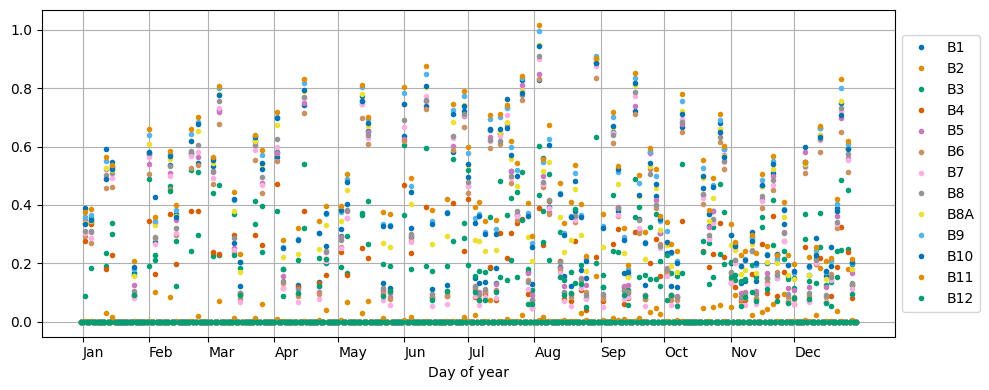

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
idx = 11345
linestyle = "."
plot_spectral_bands(
    idx, test_ds, doys_dict_test, class_names, fig, ax, linestyle=linestyle
)

## other try

In [39]:
from data.breizhcrops import BzhBreizhCrops

dataroot = os.path.join(data_path, "breizhcrops")
year = 2017
test_l1c = BzhBreizhCrops(
    "frh04",
    root=dataroot,
    transform=lambda x: x,
    preload_ram=True,
    year=year,
    level="L1C",
)

1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:46<00:00, 2655.75it/s]


In [40]:
lengths_l1c = []
for iter, (X, _, idx) in enumerate(test_l1c):
    length = (X[:, 0] != 0).sum().item()
    if iter % 1000 == 0:
        print(f"iter: {iter}, X.shape: {X.shape}, length: {length}")
    lengths_l1c.append(length)

iter: 0, X.shape: (102, 17), length: 102
iter: 1000, X.shape: (49, 17), length: 49
iter: 2000, X.shape: (102, 17), length: 102
iter: 3000, X.shape: (102, 17), length: 102
iter: 4000, X.shape: (101, 17), length: 101
iter: 5000, X.shape: (49, 17), length: 49
iter: 6000, X.shape: (50, 17), length: 50
iter: 7000, X.shape: (102, 17), length: 102
iter: 8000, X.shape: (49, 17), length: 49
iter: 9000, X.shape: (50, 17), length: 50
iter: 10000, X.shape: (101, 17), length: 101
iter: 11000, X.shape: (49, 17), length: 49
iter: 12000, X.shape: (49, 17), length: 49
iter: 13000, X.shape: (49, 17), length: 49
iter: 14000, X.shape: (102, 17), length: 102
iter: 15000, X.shape: (49, 17), length: 49
iter: 16000, X.shape: (50, 17), length: 50
iter: 17000, X.shape: (50, 17), length: 50
iter: 18000, X.shape: (102, 17), length: 102
iter: 19000, X.shape: (50, 17), length: 50
iter: 20000, X.shape: (50, 17), length: 50
iter: 21000, X.shape: (49, 17), length: 49
iter: 22000, X.shape: (49, 17), length: 49
iter: 23

In [41]:
test_l2a = BzhBreizhCrops(
    "frh04",
    root=dataroot,
    transform=lambda x: x,
    preload_ram=True,
    year=year,
    level="L2A",
)

639215848 639215848


loading data into RAM: 100%|██████████| 122708/122708 [00:43<00:00, 2812.19it/s]


In [42]:
lengths_l2a = []
for iter, (X, _, idx) in enumerate(test_l2a):
    length = (X[:, 0] != 0).sum().item()
    if iter % 1000 == 0:
        print(f"iter: {iter}, X.shape: {X.shape}, length: {length}")
    lengths_l2a.append(length)

iter: 0, X.shape: (23, 14), length: 23
iter: 1000, X.shape: (23, 14), length: 23
iter: 2000, X.shape: (25, 14), length: 25
iter: 3000, X.shape: (25, 14), length: 25
iter: 4000, X.shape: (39, 14), length: 39
iter: 5000, X.shape: (25, 14), length: 25
iter: 6000, X.shape: (27, 14), length: 27
iter: 7000, X.shape: (56, 14), length: 56
iter: 8000, X.shape: (39, 14), length: 39
iter: 9000, X.shape: (27, 14), length: 27
iter: 10000, X.shape: (25, 14), length: 25
iter: 11000, X.shape: (23, 14), length: 23
iter: 12000, X.shape: (56, 14), length: 56
iter: 13000, X.shape: (39, 14), length: 39
iter: 14000, X.shape: (27, 14), length: 27
iter: 15000, X.shape: (25, 14), length: 25
iter: 16000, X.shape: (23, 14), length: 23
iter: 17000, X.shape: (27, 14), length: 27
iter: 18000, X.shape: (60, 14), length: 60
iter: 19000, X.shape: (23, 14), length: 23
iter: 20000, X.shape: (27, 14), length: 27
iter: 21000, X.shape: (25, 14), length: 25
iter: 22000, X.shape: (23, 14), length: 23
iter: 23000, X.shape: (3

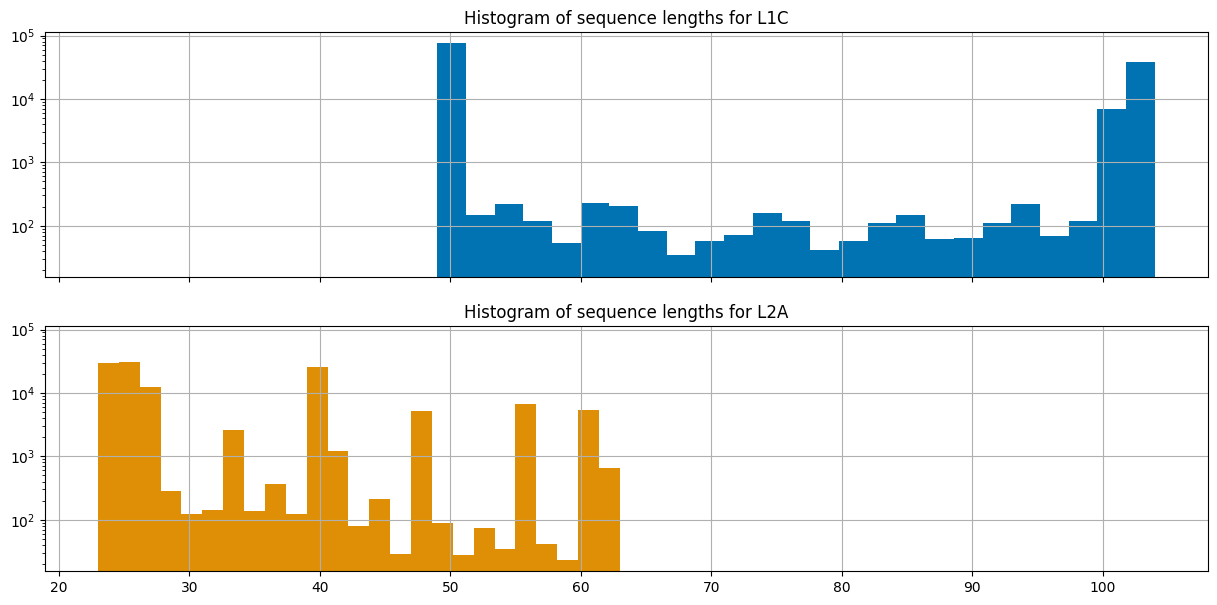

In [43]:
# two histogram, one for L1C and one for L2A lengths
fig, axes = plt.subplots(2, 1, figsize=(15, 7), sharex=True, sharey=True)
axes[0].hist(
    lengths_l1c, bins=25, label="L1C", histtype="bar", color=PALETTE[0], log=True
)
axes[1].hist(
    lengths_l2a, bins=25, label="L2A", histtype="bar", color=PALETTE[1], log=True
)
axes[0].set_title("Histogram of sequence lengths for L1C")
axes[1].set_title("Histogram of sequence lengths for L2A")
axes[0].grid()
axes[1].grid()

In [44]:
test_l1c.year

2017